<a href="https://colab.research.google.com/github/halimehrostamzadeh/My-Python-Data-Science-ML-NLP-DL/blob/master/Copy_343of_rostamzadeh_Conditional_QGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install numpy



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install pennylane

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<hr>

In [ ]:
import pennylane as qml
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
wires = range(15)
n_layers = 3
dev = qml.device('default.qubit', wires=wires)

In [ ]:
import numpy as np
from keras.datasets.mnist import load_data
from matplotlib import pyplot as plt

(trainx,trainy), (testx,testy) = load_data()

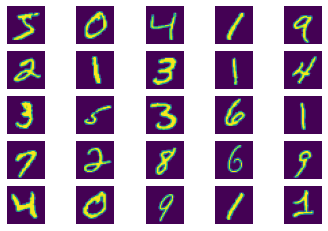

In [ ]:
for i in range(25):
  plt.subplot(5,5,1+i)
  plt.axis('off')
  plt.imshow(trainx[i])
plt.show() 

In [ ]:
dataset = np.load('/content/sample_data/dataset.npy', allow_pickle=True)

dis_dataset = dataset[1]

In [ ]:
@qml.qnode(dev, interface="tf")
def gen_circuit(b_seq, gen_weights):
    # Embedding past time series onto circuit as conditional labels
    qml.templates.AngleEmbedding(b_seq, wires, rotation='X')
        
    # Adjusting parameters of generator ansatz
    qml.templates.StronglyEntanglingLayers(gen_weights, wires=wires)
    
    # Returning normalized percentage price predictions for next 4 days in dataset 
    return [qml.expval(qml.PauliZ(i)) for i in range(len(dis_dataset[0][1][1]))]

In [ ]:
init_gen_weights = tf.Variable(np.random.uniform(-np.pi, np.pi, (n_layers, len(wires), 3)))

In [ ]:
init_gen_weights

<tf.Variable 'Variable:0' shape=(3, 15, 3) dtype=float64, numpy=
array([[[-0.32663584,  2.99406877,  1.03140635],
        [-0.57884628, -0.20882916, -2.26912914],
        [ 1.73936823, -2.96314022, -2.72110248],
        [ 2.9493478 , -2.8029631 ,  0.72561817],
        [-2.72127517, -0.47824797,  1.48642575],
        [-2.25516138, -0.45159489,  2.14503649],
        [ 0.79516035,  0.21270173, -1.33432189],
        [-2.61504424, -2.65510409, -2.34622957],
        [ 1.0418461 ,  2.92812991, -1.19228361],
        [ 0.95115631, -2.82856115,  1.65802419],
        [-0.51044191, -2.00123977,  0.99417803],
        [-2.98930184, -1.43194052,  2.24252485],
        [-0.67610714, -1.51091962, -1.90245724],
        [-1.99517193, -1.55178808, -1.07684532],
        [ 0.60488034,  1.47564959, -2.17845018]],

       [[-0.46375156, -0.1645755 ,  2.98931751],
        [ 1.47821116,  2.00842522, -1.12546734],
        [ 0.18105142,  3.0463819 ,  2.08080837],
        [-2.21300232,  1.46420922, -2.01623923],
  

In [ ]:
# Testing generator circuit QNode
gen_circuit(dis_dataset[0][1][0], init_gen_weights)

<tf.Tensor: shape=(4,), dtype=float64, numpy=array([ 0.00032364,  0.00142431, -0.00084898, -0.00988141])>

In [ ]:
def make_discrim():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=1, input_shape=[1, 19]))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    
    model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=1))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    
    model.add(tf.keras.layers.Dropout(.3))
    model.add(tf.keras.layers.Dense(units=128, activation='relu'))
    model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
    
    return model

In [ ]:
discriminator = make_discrim()
discriminator.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 1, 16)             320       
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 1, 16)             0         
                                                                 
 conv1d_13 (Conv1D)          (None, 1, 16)             272       
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 1, 16)             0         
                                                                 
 dropout_6 (Dropout)         (None, 1, 16)             0         
                                                                 
 dense_12 (Dense)            (None, 1, 128)            2176      
                                                                 
 dense_13 (Dense)            (None, 1, 1)             

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def generator_loss(fake_output):
    """Calculating loss"""
    return cross_entropy(np.ones_like(fake_output), fake_output)

In [ ]:
def discriminator_loss(fake_output, real_output):    
    """Compute discriminator loss.""" 
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def accuracy(real_data, fake_data):
    m = tf.keras.metrics.MeanAbsoluteError()
    m.update_state(real_data, fake_data)
    acc = 1 - m.result().numpy()
    return acc

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(lr=0.0001)
discriminator_optimizer = tf.keras.optimizers.Adam(lr=0.0001)

In [ ]:
def train_step(equity_data, gen_weights):
    """Run train step on provided image batch."""
    with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape: 
        generated_prices = tf.concat([equity_data[0], gen_circuit(equity_data[0], gen_weights)], 0)
        generated_prices = tf.reshape(generated_prices, (1,1,(len(equity_data[0]) + len(equity_data[1]))))

        real_prices = tf.concat([equity_data[0], equity_data[1]], 0)
        real_prices = tf.reshape(real_prices, (1,1,(len(equity_data[0]) + len(equity_data[1]))))
        
        """Getting outputs from discrim"""
        real_output = discriminator(real_prices)
        fake_output = discriminator(generated_prices)
        
        """Calculating loss"""
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(fake_output, real_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, gen_weights)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(
        zip([gradients_of_generator], [gen_weights]))
    discriminator_optimizer.apply_gradients(
        zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    """Accuracy"""
    acc = accuracy(equity_data[1], gen_circuit(equity_data[0], gen_weights))
    
    return gen_loss, disc_loss, gen_weights, acc

In [ ]:
gloss = []
dloss = []
acc_results = []
epoch_acc_results = []


In [ ]:
EPOCHS = 50
batch_size = 1

def train(dataset, epochs, start_epoch=1, new_gen_w=None):    
    for epoch in range(start_epoch, start_epoch + epochs):
        if epoch == 1:
            new_gen_w = tf.Variable(np.ones_like(init_gen_weights.numpy()), dtype="float64")
            new_gen_w.assign(init_gen_weights)
        
        for i, sample in enumerate(dataset[0:batch_size]):
            sample_b = sample[0]
            sample_f = sample[1]
            gl, dl, w, acc = train_step(dataset[i], new_gen_w)
            
            new_gen_w.assign(w)
            acc_results.append(acc)
            gloss.append(gl)
            dloss.append(dl)
        
            if epoch % 10 == 0:
                print(f"Step {i} in {epoch} epoch: Gen loss: {gl} \n         Disc loss: {dl} \n             Accuracy: {acc}")
        
        epoch_acc = 0
        for i, sample in enumerate(dataset[0:batch_size]):
            epoch_acc += accuracy(sample[1], gen_circuit(sample[0], new_gen_w))
        epoch_acc = epoch_acc / len(dataset[0:batch_size])
        epoch_acc_results.append(epoch_acc)

    return new_gen_w
    

In [ ]:
new_gen_w = train(dis_dataset[0], EPOCHS, start_epoch=1) 

Step 0 in 10 epoch: Gen loss: 0.7264817357063293 
         Disc loss: 1.3195114135742188 
             Accuracy: 0.8107469975948334
Step 0 in 20 epoch: Gen loss: 0.7589430809020996 
         Disc loss: 1.250931739807129 
             Accuracy: 0.8123062252998352
Step 0 in 30 epoch: Gen loss: 0.8143578171730042 
         Disc loss: 1.1775627136230469 
             Accuracy: 0.812230259180069
Step 0 in 40 epoch: Gen loss: 0.8681988716125488 
         Disc loss: 1.0785236358642578 
             Accuracy: 0.8110873699188232
Step 0 in 50 epoch: Gen loss: 1.012056827545166 
         Disc loss: 0.9119985103607178 
             Accuracy: 0.8100327849388123


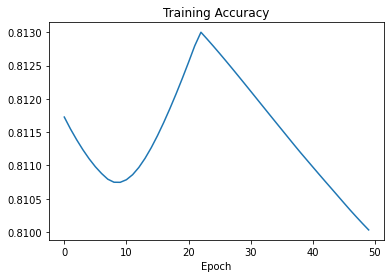

In [ ]:
plt.plot(range(len(epoch_acc_results)), epoch_acc_results)
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.show()

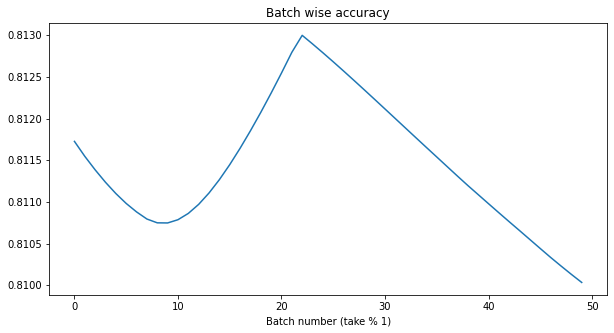

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(acc_results)), acc_results)
plt.title("Batch wise accuracy")
plt.xlabel(f"Batch number (take % {batch_size})")
plt.show()

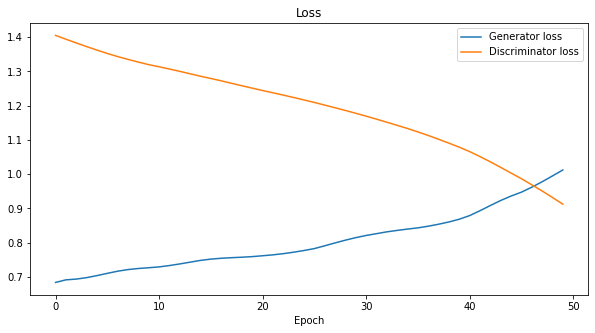

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(gloss)), gloss, label="Generator loss")
plt.plot(range(len(dloss)), dloss, label="Discriminator loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

![](./images/qgan_ex_1.png)
![](./images/qgan_ex_2.png)
![](./images/qgan_ex_3.png)
![](./images/qgan_ex_4.png)
![](./images/qgan_ex_5.png)

<hr>